In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale 
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error

from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams

# Gets the box score of every single game (NBA + WNBA + others: nba.com doesn't seperate the leagues) 
# from 2014-2021 into a dataframe.
all_games_finder = leaguegamefinder.LeagueGameFinder()
all_games = all_games_finder.get_data_frames()[0]

# Creates empty dataframe with the same column names passed in from the dataframe containing all the games.
column_names = all_games.columns
games = pd.DataFrame(columns = column_names)

# Appends every game containing an NBA team in the all_games df to the games df. 
nba_teams = teams.get_teams()
for team in nba_teams:
    temp_id = team['id']
    games = games.append(all_games[all_games['TEAM_ID'] == temp_id])

games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17985 entries, 71 to 29890
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SEASON_ID          17985 non-null  object 
 1   TEAM_ID            17985 non-null  object 
 2   TEAM_ABBREVIATION  17985 non-null  object 
 3   TEAM_NAME          17985 non-null  object 
 4   GAME_ID            17985 non-null  object 
 5   GAME_DATE          17985 non-null  object 
 6   MATCHUP            17985 non-null  object 
 7   WL                 17975 non-null  object 
 8   MIN                17985 non-null  object 
 9   PTS                17985 non-null  object 
 10  FGM                17985 non-null  object 
 11  FGA                17985 non-null  object 
 12  FG_PCT             17983 non-null  float64
 13  FG3M               17985 non-null  object 
 14  FG3A               17985 non-null  object 
 15  FG3_PCT            17982 non-null  float64
 16  FTM                17

In [2]:
# Dropping any game (two rows in DF) that has any NaN values or is missing either team's stats
games.isna()
games.dropna(inplace=True)

games = games[games.duplicated(subset = ['GAME_ID'], keep=False)]
 
# Merging games together (previously seperated in the DF by team: each team's stats from the game were kept in seperate rows
games = games.sort_values(by=['GAME_ID'])
games = games.reset_index(drop=True)

games.MATCHUP = games.MATCHUP.apply(lambda x: 'home' if 'vs' in x else x)
games.MATCHUP = games.MATCHUP.apply(lambda x: 'away' if '@' in x else x)

home = pd.DataFrame(columns = column_names)
away = pd.DataFrame(columns = column_names)

home = home.append(games[games['MATCHUP'] == 'home'])
away = away.append(games[games['MATCHUP'] == 'away'])

home = home.add_prefix('HOME_')
away = away.add_prefix('AWAY_')

home = home.reset_index(drop=True)
away = away.reset_index(drop=True)
games = home.join(away)

games.head(25)

,HOME_SEASON_ID,HOME_TEAM_ID,HOME_TEAM_ABBREVIATION,HOME_TEAM_NAME,HOME_GAME_ID,HOME_GAME_DATE,HOME_MATCHUP,HOME_WL,HOME_MIN,HOME_PTS,...,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PLUS_MINUS
0,12015,1610612746,LAC,LA Clippers,0011500001,2015-10-02,home,W,238,103,...,0.750,14,43,57,16,9,2,23,26,-7.0
1,12015,1610612753,ORL,Orlando Magic,0011500002,2015-10-03,home,L,240,100,...,0.743,7,34,41,30,7,2,13,15,6.0
2,12015,1610612754,IND,Indiana Pacers,0011500003,2015-10-03,home,L,241,105,...,0.676,19,36,55,16,9,3,11,22,5.0
3,12015,1610612747,LAL,Los Angeles Lakers,0011500004,2015-10-04,home,L,238,71,...,0.708,12,48,60,20,9,4,14,21,19.0
4,12015,1610612761,TOR,Toronto Raptors,0011500005,2015-10-04,home,W,241,93,...,0.700,5,28,33,16,6,3,24,29,-20.0
5,12015,1610612748,MIA,Miami Heat,0011500006,2015-10-04,home,L,240,77,...,0.839,7,45,52,13,7,1,16,19,13.0
6,12015,1610612757,POR,Portland Trail Blazers,0011500007,2015-10-05,home,L,266,105,...,0.643,14,36,50,25,10,5,23,18,4.0
7,12015,1610612744,GSW,Golden State Warriors,0011500009,2015-10-05,home,W,240,95,...,0.826,15,33,48,15,10,0,14,19,-8.0
8,12015,1610612747,LAL,Los Angeles Lakers,0011500010,2015-10-07,home,L,265,114,...,0.684,13,32,45,27,13,5,22,40,3.0
9,12015,1610612764,WAS,Washington Wizards,0011500011,2015-10-06,home,W,240,129,...,0.667,6,36,42,22,6,8,23,20,-34.0


In [3]:
# Dropping Non-essential categorical data
games = games.drop(columns=['HOME_SEASON_ID', 'AWAY_SEASON_ID', 'HOME_TEAM_ID', 'AWAY_TEAM_ID', 'HOME_TEAM_NAME', 'AWAY_TEAM_NAME', 'HOME_MATCHUP', 'AWAY_MATCHUP', 'HOME_WL', 'AWAY_WL', 'HOME_GAME_DATE', 'AWAY_GAME_DATE']) 

# Storing some columns for future use
game_ids = games['HOME_GAME_ID'].values
minutes = games['HOME_MIN'].values
home_abrv = games['HOME_TEAM_ABBREVIATION'].values
away_abrv = games['AWAY_TEAM_ABBREVIATION'].values

# Dropping them for normalization and correlation heatmap
games = games.drop(columns=['HOME_GAME_ID', 'AWAY_GAME_ID', 'HOME_MIN', 'AWAY_MIN', 'HOME_TEAM_ABBREVIATION', 'AWAY_TEAM_ABBREVIATION'])

# Adding minutes back as a single column
games['MIN'] = minutes
games.head()

In [4]:
# Adding Advanced Stats to enhance model performance, formulas were gathered from various sources. 

# Efficient Field Goal Percentage
games['HOME_EFG%'] = (games['HOME_FGM'] + (.5 * games['HOME_FG3M'])) / games['HOME_FGA']
games['AWAY_EFG%'] = (games['AWAY_FGM'] + (.5 * games['AWAY_FG3M'])) / games['AWAY_FGA']

# Block Percentage
games['HOME_BLK%'] = (games['HOME_BLK'] / (games['AWAY_FGA']-games['AWAY_FG3A']))
games['AWAY_BLK%'] = (games['AWAY_BLK'] / (games['HOME_FGA']-games['HOME_FG3A']))

# Turnover Percentage
games['HOME_TOV%'] = games['HOME_TOV'] / (games['HOME_FGA'] + 0.44 * games['HOME_FTA'] + games['HOME_TOV'])
games['AWAY_TOV%'] = games['AWAY_TOV'] / (games['AWAY_FGA'] + 0.44 * games['AWAY_FTA'] + games['AWAY_TOV'])

#Offensive Rebound Percentage
games['HOME_ORB%'] = games['HOME_OREB'] / (games['HOME_OREB'] + games['AWAY_DREB'])
games['AWAY_ORB%'] = games['AWAY_OREB'] / (games['AWAY_OREB'] + games['HOME_DREB'])

#Defensive Rebound Percentage
games['HOME_DREB%'] = games['HOME_DREB'] / (games['AWAY_OREB'] + games['HOME_DREB'])
games['AWAY_DREB%'] = games['AWAY_DREB'] / (games['HOME_OREB'] + games['AWAY_DREB'])

# Possessions
#games["POSS"] = 0.5*((games["FGA"] + 0.4*games["FTA"] - 1.07*(games["OREB"]/(games["OREB"] + games["OREB_other"])) * (games["FGA"] - games["FGM"]) + games["TOV"]) + games["FGA_other"] + 0.4*games["FTA_other"] - 1.07 * (games["OREB_other"] / (games["OREB_other"] + games["DREB"])) * (games["FGA_other"] - games["FGM_other]) + games["TOV_other"]))

# ***Placeholder POSS***
games['HOME_POSS'] = 0.96*((games['HOME_FGA']) + games['HOME_TOV'] + 0.44 * games['HOME_FTA'] - games['HOME_OREB'])
games['AWAY_POSS'] = 0.96*((games['AWAY_FGA']) + games['AWAY_TOV'] + 0.44 * games['AWAY_FTA'] - games['AWAY_OREB'])

# Steals Percentage
games['HOME_STL%'] = (games['HOME_STL'] / games['AWAY_POSS'])
games['AWAY_STL%'] = (games['AWAY_STL'] / games['HOME_POSS'])

# Free Throw Rate
games['HOME_FTR'] = games['HOME_FTM'] / games['HOME_FGA']
games['AWAY_FTR'] = games['AWAY_FTM'] / games['AWAY_FGA']

# True Shooting (Requires True Shooting Attempts)
home_tsa = games['HOME_FGA'] + 0.44 * games['HOME_FTA']
away_tsa = games['AWAY_FGA'] + 0.44 * games['AWAY_FTA']
games['HOME_TS'] = games['HOME_PTS'] / (2 * home_tsa)
games['AWAY_TS'] = games['AWAY_PTS'] / (2 * away_tsa)

# Assist Rate
games['HOME_ASTR'] = games['HOME_AST'] / (games['HOME_FGA'] + (.44 * games['HOME_FTA']) + games['HOME_AST'] + games['HOME_TOV'])
games['AWAY_ASTR'] = games['AWAY_AST'] / (games['AWAY_FGA'] + (.44 * games['AWAY_FTA']) + games['AWAY_AST'] + games['AWAY_TOV'])

# Total Rebound Percentage
games['HOME_TRB%'] = (games['HOME_REB'] * (games['HOME_REB'] / 5)) / (games['MIN'] * (games['HOME_REB'] + games['AWAY_REB']))
games['AWAY_TRB%'] = (games['AWAY_REB'] * (games['AWAY_REB'] / 5)) / (games['MIN'] * (games['AWAY_REB'] + games['HOME_REB']))

# PACE
games['HOME_PACE'] = 48 * (games['HOME_POSS'] + games['AWAY_POSS']) / (2 * (games['MIN'] / 5))
games['AWAY_PACE'] = 48 * (games['AWAY_POSS'] + games['HOME_POSS']) / (2 * (games['MIN'] / 5))

# Offensive Rating
games['HOME_ORTG'] = (games['HOME_PTS'] / games['HOME_POSS'])
games['AWAY_ORTG'] = (games['AWAY_PTS'] / games['AWAY_POSS'])

# Defensive Rating
games['HOME_DRTG'] = (games['AWAY_PTS'] / games['HOME_POSS'])
games['AWAY_DRTG'] = (games['HOME_PTS'] / games['AWAY_POSS'])
games.head(10)

In [5]:
# Dropping points because we already have the point spread
games = games.drop(columns=['HOME_PTS', 'AWAY_PTS'])

# Converting entire DF to numeric
games = games.apply(pd.to_numeric, errors='coerce')

# Doing data normalization
# realcols = list(games.columns.values)

# for col in realcols:
#   mean = games[col].mean()
#   std = games[col].std()
#   games[col] = (games[col] - mean)/std


In [6]:
pd.set_option('display.max_rows', None)
print(games.corr()['HOME_PLUS_MINUS'])

HOME_FG_PCT        0.535676
HOME_FG3_PCT       0.418617
HOME_FT_PCT        0.121088
HOME_PLUS_MINUS    1.000000
AWAY_FG_PCT       -0.534633
AWAY_FG3_PCT      -0.403362
AWAY_FT_PCT       -0.133429
AWAY_PLUS_MINUS   -0.999391
Name: HOME_PLUS_MINUS, dtype: float64


In [7]:
# plt.figure(figsize=(50,50))
# sns.heatmap(games.corr(),annot = True, cmap='coolwarm', vmin = -1)

In [8]:
# Dropping uncorrelated values to reduce overfitting
games = games.drop(columns = ['HOME_FGM','AWAY_FGM'])
games = games.drop(columns = ['HOME_FGA','AWAY_FGA'])
games = games.drop(columns = ['HOME_FG_PCT','AWAY_FG_PCT'])
games = games.drop(columns = ['HOME_FG3M','AWAY_FG3M'])
games = games.drop(columns = ['HOME_FG3A','AWAY_FG3A'])
games = games.drop(columns = ['HOME_FG3_PCT','AWAY_FG3_PCT'])
games = games.drop(columns = ['HOME_FTM','AWAY_FTM'])
games = games.drop(columns = ['HOME_FTA','AWAY_FTA'])
games = games.drop(columns = ['HOME_FT_PCT','AWAY_FT_PCT'])
games = games.drop(columns = ['HOME_OREB','AWAY_OREB'])
games = games.drop(columns = ['HOME_DREB','AWAY_DREB'])
games = games.drop(columns = ['HOME_REB','AWAY_REB'])
games = games.drop(columns = ['HOME_AST','AWAY_AST'])
games = games.drop(columns = ['HOME_STL','AWAY_STL'])
games = games.drop(columns = ['HOME_BLK','AWAY_BLK'])
games = games.drop(columns = ['HOME_TOV','AWAY_TOV'])
games = games.drop(columns = ['HOME_PF','AWAY_PF'])
games = games.drop(columns = ['HOME_POSS','AWAY_POSS'])
games = games.drop(columns = ['HOME_FTR','AWAY_FTR'])
games = games.drop(columns = ['HOME_PACE','AWAY_PACE'])
games = games.drop(columns = ['MIN'])


# Update CSV
games_csv = games
games_csv.to_csv("games_updated.csv", index=False)
games.head()

,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,...,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF,AWAY_PLUS_MINUS
0,103,37,91,0.407,9,32,0.281,20,26,0.769,...,0.750,14,43,57,16,9,2,23,26,-7.0
1,100,39,89,0.438,6,26,0.231,16,19,0.842,...,0.743,7,34,41,30,7,2,13,15,6.0
2,105,38,92,0.413,10,35,0.286,19,31,0.613,...,0.676,19,36,55,16,9,3,11,22,5.0
3,71,26,90,0.289,6,23,0.261,13,21,0.619,...,0.708,12,48,60,20,9,4,14,21,19.0
4,93,31,73,0.425,2,11,0.182,29,36,0.806,...,0.700,5,28,33,16,6,3,24,29,-20.0


In [9]:
games = pd.read_csv('games_updated.csv')

y = games['HOME_PLUS_MINUS'].values
z = games['AWAY_PLUS_MINUS'].values

games = games.drop(columns = ['HOME_PLUS_MINUS'])
games = games.drop(columns = ['AWAY_PLUS_MINUS'])

x = games.copy()

pd.set_option('display.max_columns', None)
games.head()

,HOME_PTS,HOME_FGM,HOME_FGA,HOME_FG_PCT,HOME_FG3M,HOME_FG3A,HOME_FG3_PCT,HOME_FTM,HOME_FTA,HOME_FT_PCT,HOME_OREB,HOME_DREB,HOME_REB,HOME_AST,HOME_STL,HOME_BLK,HOME_TOV,HOME_PF,AWAY_PTS,AWAY_FGM,AWAY_FGA,AWAY_FG_PCT,AWAY_FG3M,AWAY_FG3A,AWAY_FG3_PCT,AWAY_FTM,AWAY_FTA,AWAY_FT_PCT,AWAY_OREB,AWAY_DREB,AWAY_REB,AWAY_AST,AWAY_STL,AWAY_BLK,AWAY_TOV,AWAY_PF
0,103,37,91,0.407,9,32,0.281,20,26,0.769,9,30,39,22,12,6,13,15,96,37,87,0.425,7,18,0.389,15,20,0.750,14,43,57,16,9,2,23,26
1,100,39,89,0.438,6,26,0.231,16,19,0.842,12,33,45,22,11,3,12,30,106,34,75,0.453,12,31,0.387,26,35,0.743,7,34,41,30,7,2,13,15
2,105,38,92,0.413,10,35,0.286,19,31,0.613,18,44,62,21,10,16,19,27,110,37,103,0.359,11,32,0.344,25,37,0.676,19,36,55,16,9,3,11,22
3,71,26,90,0.289,6,23,0.261,13,21,0.619,14,34,48,11,8,6,13,31,90,27,73,0.370,2,15,0.133,34,48,0.708,12,48,60,20,9,4,14,21
4,93,31,73,0.425,2,11,0.182,29,36,0.806,9,39,48,11,12,6,19,25,73,27,71,0.380,5,15,0.333,14,20,0.700,5,28,33,16,6,3,24,29


In [10]:
# Basic Linear Regression
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 1)

xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

xtrain.shape, xtest.shape, ytrain.shape, ytest.shape

from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(xtrain, ytrain)
reg.score(xtrain, ytrain), reg.score(xtest, ytest)

(0.996013026003249, 0.9969592988491441)

HOME_PTS         0.406658
HOME_FGM         0.811290
HOME_FGA         0.125729
HOME_FG_PCT     27.334860
HOME_FG3M        0.565937
HOME_FG3A        0.005872
HOME_FG3_PCT     0.289268
HOME_FTM         0.434757
HOME_FTA         0.093393
HOME_FT_PCT      2.986135
HOME_OREB        0.009063
HOME_DREB        0.015809
HOME_REB         0.013876
HOME_AST         0.013330
HOME_STL         0.004537
HOME_BLK        -0.005818
HOME_TOV        -0.048965
HOME_PF         -0.013873
AWAY_PTS        -0.399976
AWAY_FGM        -0.820911
AWAY_FGA        -0.125002
AWAY_FG_PCT    -28.230250
AWAY_FG3M       -0.561361
AWAY_FG3A       -0.008809
AWAY_FG3_PCT    -0.646274
AWAY_FTM        -0.452414
AWAY_FTA        -0.074696
AWAY_FT_PCT     -2.675462
AWAY_OREB       -0.005590
AWAY_DREB       -0.020467
AWAY_REB        -0.016180
AWAY_AST        -0.010499
AWAY_STL        -0.004319
AWAY_BLK         0.002800
AWAY_TOV         0.049928
AWAY_PF         -0.003373
dtype: float64
Test mean squared error (MSE): 0.74
0.99650708461

<AxesSubplot:>

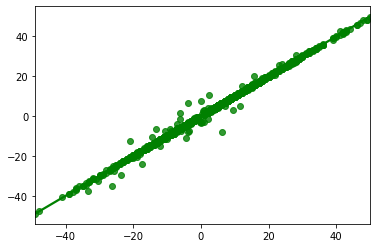

In [11]:
#Lasso regression
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

alphas = 10**np.linspace(10,-2,100)*0.5
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(xtrain, ytrain)
    coefs.append(ridge.coef_)
    
np.shape(coefs) 

pred1 = ridge.predict(xtest)     

print(pd.Series(ridge.coef_, index = games.columns)) # Print coefficients
mse = mean_squared_error(ytest, pred1)          # Calculate the test MSE
print("Test mean squared error (MSE): {:.2f}".format(mse))

# print score
print(ridge.score(xtest, ytest))
sns.regplot(x=ytest, y=pred1, color="g")

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

# create decision tree classifier 
# criterion='entropy'
clf_1 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 1, random_state = 30, max_leaf_nodes = 5)
clf_2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 2, random_state = 30, max_leaf_nodes = 10)
clf_3 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 30, max_leaf_nodes = 15)
clf_4 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 25, random_state = 30, max_leaf_nodes = 25)

# fit regression model on train set
clf_1.fit(xtrain, ytrain)
clf_2.fit(xtrain, ytrain)
clf_3.fit(xtrain, ytrain)
clf_4.fit(xtrain, ytrain)

#predict on test set
y_1 = clf_1.predict(xtest)
y_2 = clf_2.predict(xtest)
y_3 = clf_3.predict(xtest)
y_4 = clf_4.predict(xtest)

#calculate mean_squared_error
print(mean_squared_error(ytest, y_1))
print(mean_squared_error(ytest, y_2))
print(mean_squared_error(ytest, y_3))
print(mean_squared_error(ytest, y_4))